# Data Processing and Modeling for Zillow's Home Value Prediction

The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016

The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.

You are asked to predict 6 time points for all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

Not all the properties are sold in each time period. If a property was not sold in a certain time period, that particular row will be ignored when calculating your score.

In [1]:
import src.data_proc as data_proc

import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
%%time
# Load in properties data
prop_2016 = data_proc.load_properties_data("data/properties_2016.csv")
prop_2017 = data_proc.load_properties_data("data/properties_2017.csv")

assert len(prop_2016) == len(prop_2017)
print("Number of properties: {}".format(len(prop_2016)))
print("Number of property features: {}".format(len(prop_2016.columns)-1))

Number of properties: 2985217
Number of property features: 57
CPU times: user 32.4 s, sys: 6.01 s, total: 38.4 s
Wall time: 38.4 s


In [3]:
# Load in training data (with logerror labels)
train_2016 = data_proc.load_training_data("data/train_2016_v2.csv")
train_2017 = data_proc.load_training_data("data/train_2017.csv")

print("Number of 2016 transaction records: {}".format(len(train_2016)))
print("Number of 2016 transaction records: {}".format(len(train_2017)))
print("\n", train_2016.head())
print("\n", train_2017.head())

Number of 2016 transaction records: 90275
Number of 2016 transaction records: 77613

    parcelid  logerror transactiondate
0  11016594    0.0276      2016-01-01
1  14366692   -0.1684      2016-01-01
2  12098116   -0.0040      2016-01-01
3  12643413    0.0218      2016-01-02
4  14432541   -0.0050      2016-01-02

    parcelid  logerror transactiondate
0  14297519  0.025595      2017-01-01
1  17052889  0.055619      2017-01-01
2  14186244  0.005383      2017-01-01
3  12177905 -0.103410      2017-01-01
4  10887214  0.006940      2017-01-01


In [4]:
# Rename & retype the feature columns; also unify representations of missing values
for p in [prop_2016, prop_2017]:
    data_proc.rename_columns(p)
    data_proc.retype_columns(p)

prop_2017.head()

,parcelid,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,10754147,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34144440.0,-118654080.0,85768.0,NaN,NaN,NaN,NaN,NaN,010D,238,NaN,60378004.0,37688.0,1815,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,-1,-1,NaN,0.0,0.0,-1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34140432.0,-118625360.0,4083.0,NaN,NaN,NaN,NaN,NaN,0109,230,LCA11*,60378000.0,37688.0,1815,NaN,96337.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,-1,-1,NaN,0.0,0.0,4,-1,NaN,NaN,NaN,73026.0,NaN,NaN,73026.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,33989360.0,-118394632.0,63085.0,NaN,NaN,NaN,NaN,NaN,1200,16,LAC2,60377032.0,51617.0,1815,NaN,96095.0,0.0,NaN,NaN,-1,2.0,NaN,NaN,1959.0,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.369141,NaN,NaN,NaN
3,10859147,-1,-1,NaN,0.0,0.0,2,5,NaN,NaN,NaN,5068.0,NaN,NaN,5068.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34148864.0,-118437208.0,7521.0,NaN,NaN,NaN,NaN,NaN,1200,16,LAC2,60371412.0,12447.0,1815,27080.0,96424.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1948.0,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.570312,NaN,NaN,NaN
4,10879947,-1,-1,NaN,0.0,0.0,3,-1,NaN,NaN,NaN,1776.0,NaN,NaN,1776.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,-1,34194168.0,-118385816.0,8512.0,NaN,NaN,NaN,NaN,NaN,1210,0,LAM1,60371232.0,12447.0,1815,46795.0,96450.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1947.0,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.169922,NaN,NaN,NaN


In [5]:
# Join the training data with the property table
train_2016 = train_2016.merge(how='left', right=prop_2016, on='parcelid')
train_2017 = train_2017.merge(how='left', right=prop_2017, on='parcelid')

# Remove outliers from training set
threshold = 0.6
print("Remove outliers for 2016 training set:")
train_2016 = data_proc.remove_outliers(train_2016, threshold)
print("\nRemove outliers for 2017 training set:")
train_2017 = data_proc.remove_outliers(train_2017, threshold)

# Combine the 2016 and 2017 training sets
train = pd.concat([train_2016, train_2017], axis=0, ignore_index=True)
print("\nCombined training set size: {}".format(len(train)))

train.head(20)

Remove outliers for 2016 training set:
90275 training examples in total
951 with abs(logerror) > 0.6
New training set size (outliers removed): 89324

Remove outliers for 2017 training set:
77613 training examples in total
895 with abs(logerror) > 0.6
New training set size (outliers removed): 76718

Combined training set size: 166042


,parcelid,logerror,transactiondate,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,11016594,0.0276,2016-01-01,0,-1,NaN,2.0,3.0,-1,3,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,230,LARS,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,-1,-1,NaN,3.5,4.0,-1,-1,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,230,NaN,60590524.0,32380.0,0,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,0,-1,NaN,3.0,2.0,-1,3,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,230,PSR6,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,0,-1,NaN,2.0,2.0,-1,3,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,235,LAR3,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,-1,-1,NaN,2.5,4.0,-1,-1,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,230,NaN,60590424.0,17686.0,0,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,0,-1,NaN,4.0,4.0,-1,0,4.0,NaN,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,NaN,0100,230,HBR3YY,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,-1,-1,NaN,1.0,2.0,-1,6,1.0,NaN,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,NaN,0100,230,CORH*,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,-1,-1,NaN,2.5,3.0,-1,-1,2.5,NaN,853.0,1763.0,1763.0,NaN,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,235,NaN,61110032.0,13150.0,775,NaN,97101.0,6.0,NaN,1.0,-1,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,-1,-1,NaN,1.0,2.0,-1,-1,1.0,NaN,NaN,796.0,796.0,NaN,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,-1,-1,NaN,2.0,2.0,-1,-1,2.0,NaN,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,-1,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960.0,2015.0,80983

In [6]:
# Add datetime features
logerror_year, logerror_month, logerror_quarter = data_proc.compute_datetime_aggregate_features(train)
train = data_proc.add_datetime_aggregate_features(train, logerror_year, logerror_month, logerror_quarter)    

# TODO: Derive location related features

# Drop features that are not useful or too messy
lgb_features = data_proc.drop_features(train)

print("Number of features for LightGBM: {}".format(len(lgb_features.columns)))
lgb_features.head(10)

Number of features for LightGBM: 58


,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,landuse_type_id,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2,logerror_year,logerror_month,logerror_quarter
0,0,-1,NaN,2.0,3.0,-1,3,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,230,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13,0.005,0.01,0.006
1,-1,-1,NaN,3.5,4.0,-1,-1,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,230,60590524.0,32380.0,0,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN,0.005,0.01,0.006
2,0,-1,NaN,3.0,2.0,-1,3,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,230,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13,0.005,0.01,0.006
3,0,-1,NaN,2.0,2.0,-1,3,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,235,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13,0.005,0.01,0.006
4,-1,-1,NaN,2.5,4.0,-1,-1,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,230,60590424.0,17686.0,0,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13,0.005,0.01,0.006
5,0,-1,NaN,4.0,4.0,-1,0,4.0,NaN,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,NaN,230,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13,0.005,0.01,0.006
6,-1,-1,NaN,1.0,2.0,-1,6,1.0,NaN,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,NaN,230,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13,0.005,0.01,0.006
7,-1,-1,NaN,2.5,3.0,-1,-1,2.5,NaN,853.0,1763.0,1763.0,NaN,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,NaN,235,61110032.0,13150.0,775,NaN,97101.0,6.0,NaN,1.0,-1,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13,0.005,0.01,0.006
8,-1,-1,NaN,1.0,2.0,-1,-1,1.0,NaN,NaN,796.0,796.0,NaN,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,NaN,235,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13,0.005,0.01,0.006
9,-1,-1,NaN,2.0,2.0,-1,-1,2.0,NaN,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,NaN,235,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,-1,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960.0,2015.0,80983.0,1940.260010,NaN,NaN,6.059063e+13,0.005,0.01,0.006


In [7]:
# Prepare data for LightGBM
lgb_label = train.logerror.astype(np.float32)
print(lgb_label.head())

# Transform to Numpy matrices and perform train/val split
lgb_X = lgb_features.values
lgb_y = lgb_label.values

np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y, test_size=0.2)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

0    0.0276
1   -0.1684
2   -0.0040
3    0.0218
4   -0.0050
Name: logerror, dtype: float32
X_train shape: (132833, 58)
y_train shape: (132833,)
X_val shape: (33209, 58)
y_val shape: (33209,)


In [32]:
# LightGBM parameters
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4  # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 2000
params['learning_rate'] = 0.001  # shrinkage_rate
params['early_stopping_rounds'] = 20  # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 512  # max number of leaves in one tree (default 31)
params['min_data'] = 100  # min_data_in_leaf
params['min_hessian'] = 0.05  # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1  # limit the max depth of tree model, defult -1 (no limit)
params['max_bin'] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params['sub_feature'] = 0.65    # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params['bagging_fraction'] = 0.75
params['bagging_freq'] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 15.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [34]:
# Train LightGBM
feature_names = [s for s in lgb_features.columns]
categorical_indices = []
for i, t in enumerate(lgb_features.dtypes):
    if t.name == 'category':
        categorical_indices.append(i)

lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

np.random.seed(42)
random.seed(36)
clf = lgb.train(params, lgb_train_set, verbose_eval=True,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=categorical_indices)

# Evaluate on validation set
print("Train score: {}".format(abs(clf.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(clf.predict(X_val) - y_val).mean() * 100))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 5, 6, 16, 22, 34, 40]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's l1: 0.0572482	val's l1: 0.0570006
Training until validation scores don't improve for 20 rounds.
[2]	train's l1: 0.0572451	val's l1: 0.0569989
[3]	train's l1: 0.0572419	val's l1: 0.0569972
[4]	train's l1: 0.0572392	val's l1: 0.0569958
[5]	train's l1: 0.0572361	val's l1: 0.0569942
[6]	train's l1: 0.057233	val's l1: 0.0569925
[7]	train's l1: 0.0572302	val's l1: 0.0569911
[8]	train's l1: 0.0572272	val's l1: 0.0569897
[9]	train's l1: 0.0572242	val's l1: 0.0569881
[10]	train's l1: 0.0572213	val's l1: 0.0569866
[11]	train's l1: 0.0572184	val's l1: 0.056985
[12]	train's l1: 0.0572153	val's l1: 0.0569836
[13]	train's l1: 0.0572126	val's l1: 0.0569823
[14]	train's l1: 0.0572098	val's l1: 0.056981
[15]	train's l1: 0.0572069	val's l1: 0.0569795
[16]	train's l1: 0.057204	val's l1: 0.056978
[17]	train's l1: 0.0572013	val's l1: 0.0569767
[18]	train's l1: 0.0571985	val's l1: 0.0569754
[19]	train's l1: 0.0571958	val's l1: 0.0569741
[20]	train's l1: 0.057193	val's l1: 0.0569727
[21]	train's 

[178]	train's l1: 0.056782	val's l1: 0.0567854
[179]	train's l1: 0.0567795	val's l1: 0.0567843
[180]	train's l1: 0.056777	val's l1: 0.0567832
[181]	train's l1: 0.0567744	val's l1: 0.0567821
[182]	train's l1: 0.056772	val's l1: 0.056781
[183]	train's l1: 0.0567694	val's l1: 0.0567799
[184]	train's l1: 0.056767	val's l1: 0.0567788
[185]	train's l1: 0.0567645	val's l1: 0.056778
[186]	train's l1: 0.056762	val's l1: 0.0567769
[187]	train's l1: 0.0567594	val's l1: 0.0567758
[188]	train's l1: 0.056757	val's l1: 0.0567748
[189]	train's l1: 0.0567545	val's l1: 0.0567739
[190]	train's l1: 0.0567522	val's l1: 0.0567727
[191]	train's l1: 0.05675	val's l1: 0.0567717
[192]	train's l1: 0.0567476	val's l1: 0.0567707
[193]	train's l1: 0.0567453	val's l1: 0.0567699
[194]	train's l1: 0.0567429	val's l1: 0.0567689
[195]	train's l1: 0.0567405	val's l1: 0.056768
[196]	train's l1: 0.0567381	val's l1: 0.0567669
[197]	train's l1: 0.0567357	val's l1: 0.0567657
[198]	train's l1: 0.0567334	val's l1: 0.0567647
[19

[352]	train's l1: 0.0563911	val's l1: 0.0566345
[353]	train's l1: 0.056389	val's l1: 0.0566337
[354]	train's l1: 0.0563869	val's l1: 0.0566329
[355]	train's l1: 0.0563847	val's l1: 0.0566322
[356]	train's l1: 0.0563825	val's l1: 0.0566316
[357]	train's l1: 0.0563801	val's l1: 0.0566308
[358]	train's l1: 0.0563778	val's l1: 0.0566299
[359]	train's l1: 0.0563756	val's l1: 0.0566293
[360]	train's l1: 0.0563734	val's l1: 0.0566285
[361]	train's l1: 0.0563712	val's l1: 0.0566276
[362]	train's l1: 0.0563692	val's l1: 0.0566268
[363]	train's l1: 0.0563671	val's l1: 0.0566261
[364]	train's l1: 0.056365	val's l1: 0.0566253
[365]	train's l1: 0.056363	val's l1: 0.0566246
[366]	train's l1: 0.0563607	val's l1: 0.056624
[367]	train's l1: 0.0563587	val's l1: 0.0566233
[368]	train's l1: 0.0563565	val's l1: 0.0566226
[369]	train's l1: 0.0563545	val's l1: 0.056622
[370]	train's l1: 0.0563525	val's l1: 0.0566214
[371]	train's l1: 0.0563504	val's l1: 0.0566209
[372]	train's l1: 0.0563481	val's l1: 0.05662

[527]	train's l1: 0.0560457	val's l1: 0.0565248
[528]	train's l1: 0.0560438	val's l1: 0.0565243
[529]	train's l1: 0.0560418	val's l1: 0.0565236
[530]	train's l1: 0.0560398	val's l1: 0.056523
[531]	train's l1: 0.0560378	val's l1: 0.0565225
[532]	train's l1: 0.0560357	val's l1: 0.0565219
[533]	train's l1: 0.0560339	val's l1: 0.0565214
[534]	train's l1: 0.056032	val's l1: 0.0565208
[535]	train's l1: 0.0560303	val's l1: 0.0565204
[536]	train's l1: 0.0560284	val's l1: 0.0565197
[537]	train's l1: 0.0560265	val's l1: 0.0565191
[538]	train's l1: 0.0560247	val's l1: 0.0565187
[539]	train's l1: 0.0560228	val's l1: 0.0565183
[540]	train's l1: 0.056021	val's l1: 0.0565179
[541]	train's l1: 0.0560193	val's l1: 0.0565175
[542]	train's l1: 0.0560174	val's l1: 0.0565168
[543]	train's l1: 0.0560156	val's l1: 0.0565162
[544]	train's l1: 0.0560137	val's l1: 0.0565158
[545]	train's l1: 0.056012	val's l1: 0.0565152
[546]	train's l1: 0.0560101	val's l1: 0.0565147
[547]	train's l1: 0.0560082	val's l1: 0.0565

[699]	train's l1: 0.0557416	val's l1: 0.0564474
[700]	train's l1: 0.05574	val's l1: 0.0564471
[701]	train's l1: 0.0557383	val's l1: 0.0564466
[702]	train's l1: 0.0557368	val's l1: 0.0564463
[703]	train's l1: 0.055735	val's l1: 0.0564459
[704]	train's l1: 0.0557333	val's l1: 0.0564456
[705]	train's l1: 0.0557317	val's l1: 0.0564454
[706]	train's l1: 0.0557301	val's l1: 0.056445
[707]	train's l1: 0.0557283	val's l1: 0.0564447
[708]	train's l1: 0.0557267	val's l1: 0.0564443
[709]	train's l1: 0.055725	val's l1: 0.056444
[710]	train's l1: 0.0557234	val's l1: 0.0564436
[711]	train's l1: 0.0557217	val's l1: 0.0564433
[712]	train's l1: 0.05572	val's l1: 0.0564429
[713]	train's l1: 0.0557184	val's l1: 0.0564427
[714]	train's l1: 0.0557167	val's l1: 0.0564422
[715]	train's l1: 0.0557151	val's l1: 0.0564418
[716]	train's l1: 0.0557135	val's l1: 0.0564416
[717]	train's l1: 0.0557116	val's l1: 0.0564411
[718]	train's l1: 0.05571	val's l1: 0.0564406
[719]	train's l1: 0.0557083	val's l1: 0.0564402
[7

[871]	train's l1: 0.0554658	val's l1: 0.0563952
[872]	train's l1: 0.0554642	val's l1: 0.0563951
[873]	train's l1: 0.0554625	val's l1: 0.0563947
[874]	train's l1: 0.055461	val's l1: 0.0563946
[875]	train's l1: 0.0554595	val's l1: 0.0563944
[876]	train's l1: 0.055458	val's l1: 0.0563942
[877]	train's l1: 0.0554565	val's l1: 0.0563939
[878]	train's l1: 0.055455	val's l1: 0.0563936
[879]	train's l1: 0.0554534	val's l1: 0.0563934
[880]	train's l1: 0.0554518	val's l1: 0.0563931
[881]	train's l1: 0.0554503	val's l1: 0.0563928
[882]	train's l1: 0.0554487	val's l1: 0.0563926
[883]	train's l1: 0.0554472	val's l1: 0.0563923
[884]	train's l1: 0.0554456	val's l1: 0.0563921
[885]	train's l1: 0.055444	val's l1: 0.0563919
[886]	train's l1: 0.0554424	val's l1: 0.0563917
[887]	train's l1: 0.0554409	val's l1: 0.0563914
[888]	train's l1: 0.0554393	val's l1: 0.056391
[889]	train's l1: 0.0554378	val's l1: 0.0563906
[890]	train's l1: 0.0554362	val's l1: 0.0563905
[891]	train's l1: 0.0554348	val's l1: 0.05639

[1045]	train's l1: 0.055212	val's l1: 0.0563677
[1046]	train's l1: 0.0552108	val's l1: 0.0563677
[1047]	train's l1: 0.0552093	val's l1: 0.0563677
[1048]	train's l1: 0.0552078	val's l1: 0.0563677
[1049]	train's l1: 0.0552064	val's l1: 0.0563675
[1050]	train's l1: 0.0552052	val's l1: 0.0563674
[1051]	train's l1: 0.0552038	val's l1: 0.0563674
[1052]	train's l1: 0.0552023	val's l1: 0.0563673
[1053]	train's l1: 0.0552009	val's l1: 0.0563671
[1054]	train's l1: 0.0551995	val's l1: 0.0563669
[1055]	train's l1: 0.055198	val's l1: 0.0563668
[1056]	train's l1: 0.0551966	val's l1: 0.0563664
[1057]	train's l1: 0.0551952	val's l1: 0.0563661
[1058]	train's l1: 0.0551938	val's l1: 0.0563659
[1059]	train's l1: 0.0551924	val's l1: 0.0563657
[1060]	train's l1: 0.055191	val's l1: 0.0563654
[1061]	train's l1: 0.0551896	val's l1: 0.0563655
[1062]	train's l1: 0.0551881	val's l1: 0.0563654
[1063]	train's l1: 0.0551866	val's l1: 0.0563655
[1064]	train's l1: 0.0551852	val's l1: 0.0563652
[1065]	train's l1: 0.05

[1215]	train's l1: 0.0549772	val's l1: 0.0563448
[1216]	train's l1: 0.0549758	val's l1: 0.0563445
[1217]	train's l1: 0.0549743	val's l1: 0.0563445
[1218]	train's l1: 0.054973	val's l1: 0.0563445
[1219]	train's l1: 0.0549717	val's l1: 0.0563447
[1220]	train's l1: 0.0549704	val's l1: 0.0563445
[1221]	train's l1: 0.054969	val's l1: 0.0563445
[1222]	train's l1: 0.0549676	val's l1: 0.0563444
[1223]	train's l1: 0.0549662	val's l1: 0.0563443
[1224]	train's l1: 0.0549649	val's l1: 0.0563443
[1225]	train's l1: 0.0549637	val's l1: 0.0563443
[1226]	train's l1: 0.0549623	val's l1: 0.0563441
[1227]	train's l1: 0.0549608	val's l1: 0.056344
[1228]	train's l1: 0.0549593	val's l1: 0.0563438
[1229]	train's l1: 0.0549581	val's l1: 0.0563437
[1230]	train's l1: 0.0549568	val's l1: 0.0563436
[1231]	train's l1: 0.0549554	val's l1: 0.0563437
[1232]	train's l1: 0.054954	val's l1: 0.0563438
[1233]	train's l1: 0.0549526	val's l1: 0.0563437
[1234]	train's l1: 0.0549512	val's l1: 0.0563437
[1235]	train's l1: 0.054

[1388]	train's l1: 0.0547507	val's l1: 0.0563342
[1389]	train's l1: 0.0547494	val's l1: 0.056334
[1390]	train's l1: 0.054748	val's l1: 0.056334
[1391]	train's l1: 0.0547467	val's l1: 0.0563337
[1392]	train's l1: 0.0547454	val's l1: 0.0563337
[1393]	train's l1: 0.0547442	val's l1: 0.0563336
[1394]	train's l1: 0.0547429	val's l1: 0.0563335
[1395]	train's l1: 0.0547415	val's l1: 0.0563334
[1396]	train's l1: 0.0547402	val's l1: 0.0563332
[1397]	train's l1: 0.0547389	val's l1: 0.0563332
[1398]	train's l1: 0.0547376	val's l1: 0.0563331
[1399]	train's l1: 0.0547364	val's l1: 0.0563331
[1400]	train's l1: 0.0547352	val's l1: 0.0563332
[1401]	train's l1: 0.0547341	val's l1: 0.0563332
[1402]	train's l1: 0.0547329	val's l1: 0.0563332
[1403]	train's l1: 0.0547316	val's l1: 0.0563332
[1404]	train's l1: 0.0547304	val's l1: 0.0563331
[1405]	train's l1: 0.054729	val's l1: 0.0563331
[1406]	train's l1: 0.0547277	val's l1: 0.056333
[1407]	train's l1: 0.0547264	val's l1: 0.0563329
[1408]	train's l1: 0.0547

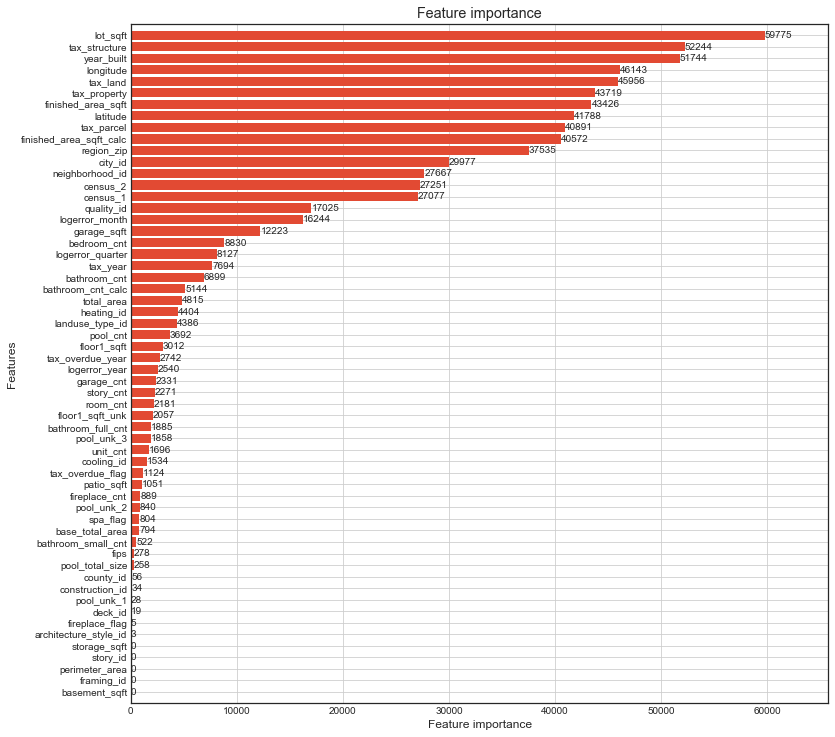

In [35]:
# Plot LightGBM feature importance
lgb.plot_importance(clf, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [36]:
%%time
def predict_and_export(clf, prop_2016, prop_2017, file_name):
    # Construct DataFrame for prediction results
    submission = pd.DataFrame()
    submission['ParcelId'] = prop_2016.parcelid
    
    # Construct features and make prediction
    test_features_2016 = data_proc.drop_features(prop_2016)
    test_features_2017 = data_proc.drop_features(prop_2017)
    
    test_dates = ['2016-10-01', '2016-11-01', '2016-12-01']
    test_columns = ['201610', '201611', '201612']
    for d, c in zip(test_dates, test_columns):
        print("Start predicting for {}".format(c))
        
        test_features = test_features_2016
        test_features['transactiondate'] = d
        test_features = data_proc.add_datetime_aggregate_features(test_features,
                                                                  logerror_year, logerror_month, logerror_quarter)

        pred_test = clf.predict(test_features)
        pred_test = [float(format(x, '.4f')) for x in pred_test]
        submission[c] = pred_test
        
        print("Finished predicting for {}".format(c))
    
    submission['201710'] = submission['201610']
    submission['201711'] = submission['201611']
    submission['201712'] = submission['201612']
    
    print("Length of submission DataFrame: {}".format(len(submission)))
    print("Submission header:")
    print(submission.head())
    submission.to_csv(file_name, index=False)
    return submission  # Return the results just in case we want to analyze or sanity check it

submission = predict_and_export(clf, prop_2016, prop_2017, 'data/submission_181229_v3.csv')

Start predicting for 201610
Finished predicting for 201610
Start predicting for 201611
Finished predicting for 201611
Start predicting for 201612
Finished predicting for 201612
Length of submission DataFrame: 2985217
Submission header:
   ParcelId  201610  201611  201612  201710  201711  201712
0  10754147 -0.0106 -0.0106 -0.0106 -0.0106 -0.0106 -0.0106
1  10759547 -0.0113 -0.0112 -0.0113 -0.0113 -0.0112 -0.0113
2  10843547 -0.0008 -0.0011 -0.0008 -0.0008 -0.0011 -0.0008
3  10859147  0.0139  0.0139  0.0139  0.0139  0.0139  0.0139
4  10879947 -0.0094 -0.0094 -0.0094 -0.0094 -0.0094 -0.0094
CPU times: user 2h 11min 51s, sys: 41 s, total: 2h 12min 32s
Wall time: 34min 18s


In [25]:
# Sweep a single hyperparameter
def sweep_hyperparam(param_name, sweep):
    feature_names = [s for s in lgb_features.columns]
    categorical_indices = []
    for i, t in enumerate(lgb_features.dtypes):
        if t.name == 'category':
            categorical_indices.append(i)

    lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
    lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=feature_names)

    train_scores = []
    val_scores = []
    for p in sweep:
        print(p)
        np.random.seed(42)
        random.seed(36)
        params[param_name] = p
        clf = lgb.train(params, lgb_train_set, verbose_eval=False,
                    valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                    categorical_feature=categorical_indices)
        train_scores.append(abs(clf.predict(X_train) - y_train).mean() * 100)
        val_scores.append(abs(clf.predict(X_val) - y_val).mean() * 100)

    for i in range(len(sweep)):
        print("{}: train {}, val {}".format(sweep[i], train_scores[i], val_scores[i]))

sweep_hyperparam('learning_rate', [0.001, 0.0012, 0.0015, 0.0018, 0.002])

0.001


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:121: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 5, 6, 16, 22, 34, 40]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


0.0012
0.0015
0.0018
0.002
0.001: train 5.46601128781077, val 5.63314063570561
0.0012: train 5.4949659174148335, val 5.635382436956213
0.0015: train 5.480147495642608, val 5.635120591330731
0.0018: train 5.480384634693824, val 5.635012578298153
0.002: train 5.477554743651726, val 5.635200104218687
